In [1]:
import os
import sys

import numpy as np
import pandas as pd

import torch
import torch.functional as F
from torch.utils.tensorboard import SummaryWriter

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
import seaborn as sns

2024-10-10 22:53:04.179208: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
SEQ_LENGTH = 128
SEQ_OVERLAP = 16
PAD_VALUE = -100.

In [3]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# DATA PREPARATION

In [4]:
# the fugue that we want to finish
# load data, 4 voices of instruments
target_data = np.loadtxt("data/contrapunctusXIV.txt")
print(target_data.shape)
print(target_data[0:10])

(3804, 4)
[[ 0.  0.  0. 42.]
 [ 0.  0.  0. 42.]
 [ 0.  0.  0. 42.]
 [ 0.  0.  0. 42.]
 [ 0.  0.  0. 42.]
 [ 0.  0.  0. 42.]
 [ 0.  0.  0. 42.]
 [ 0.  0.  0. 42.]
 [ 0.  0.  0. 49.]
 [ 0.  0.  0. 49.]]


In [5]:
# the data we have, which is other bach music, from other fugues
# load data
data = np.load('data/js-fakes-16thSeparated.npz', allow_pickle=True, encoding='latin1')
# we only use the note pitches
data = data["pitches"]

In [6]:
# change to list of dataframes
data = [pd.DataFrame(sequence) for sequence in data]
# append target important fugue we will predict on
data.append(pd.DataFrame(target_data).replace(0., -1.))
data[0]

,0,1,2,3
0,67.0,63.0,58.0,51.0
1,67.0,63.0,58.0,51.0
2,67.0,63.0,58.0,51.0
3,67.0,63.0,58.0,51.0
4,68.0,63.0,60.0,48.0
...,...,...,...,...
123,63.0,58.0,55.0,39.0
124,63.0,58.0,55.0,39.0
125,63.0,58.0,55.0,39.0
126,63.0,58.0,55.0,39.0


unique values for each of the 4 voices:
[29, 35, 34, 36]


Text(0.5, 1.0, 'Sequence length')

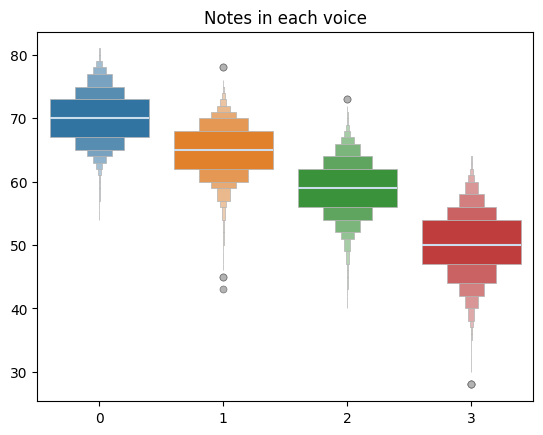

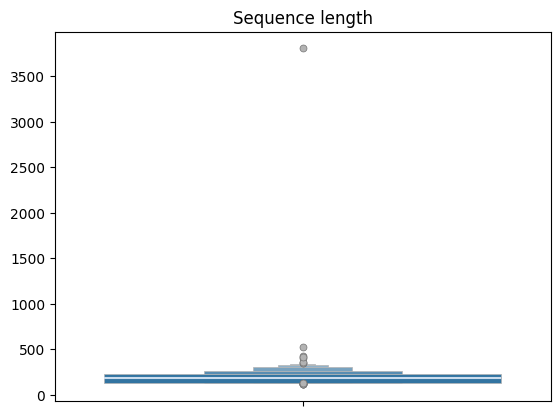

In [7]:
# check out data

# unique notes in each voice
concat_data = np.concatenate(data, axis = 0)
print("unique values for each of the 4 voices:")
print([len(set(voice)) for voice in np.transpose(concat_data)])

# boxplot of notes
concat_data = pd.DataFrame(concat_data)
sns.boxenplot(concat_data.replace(-1, np.nan), linewidth=.5, linecolor=".7",
              line_kws=dict(linewidth=1.5, color="#cde"),
              flier_kws=dict(facecolor=".7", linewidth=.5)).set_title("Notes in each voice")

plt.figure()
# boxplot of lengths
lengths = np.array([len(sequence) for sequence in data])
sns.boxenplot(lengths,linewidth=.5, linecolor=".7",
              line_kws=dict(linewidth=1.5, color="#cde"),
              flier_kws=dict(facecolor=".7", linewidth=.5)).set_title("Sequence length")

In [8]:
concat_data[~np.isclose(concat_data[1], -1.)]

,0,1,2,3
0,67.0,63.0,58.0,51.0
1,67.0,63.0,58.0,51.0
2,67.0,63.0,58.0,51.0
3,67.0,63.0,58.0,51.0
4,68.0,63.0,60.0,48.0
...,...,...,...,...
98497,-1.0,59.0,53.0,49.0
98498,-1.0,57.0,54.0,42.0
98499,-1.0,57.0,54.0,42.0
98500,-1.0,57.0,56.0,42.0


In [9]:
print([voice for voice in concat_data])

[0, 1, 2, 3]


In [10]:
# standardization, while ignoring the -1's (silences, value does not matter directly)
#   first means and stds for each voice
means = []
stds = []

for voice in concat_data:
    values = concat_data[~np.isclose(concat_data[voice], -1.)][voice]
    means.append(values.mean())
    stds.append(values.std())
    
print(means)
print(stds)

# now we standardize the values of data
for i, df in enumerate(data):
    for j, (mean, std) in enumerate(zip(means, stds)):
        indices = ~np.isclose(data[i][j], -1.)
        data[i].loc[indices, j] = (data[i].loc[indices, j] - mean) / std
        
        # We change silences to 0. (mean) and add an boolean feature 
        data[i].loc[~indices, j] = 0.
        data[i][str(j) + "s"] = 0.
        data[i].loc[~indices, str(j) + "s"] = 1.

[70.25795111120249, 64.8420438016021, 59.252596187460156, 50.245932582425475]
[4.121225334257773, 4.088873370354724, 4.454029804474629, 5.29966003147804]


Text(0.5, 1.0, 'Notes in each voice')

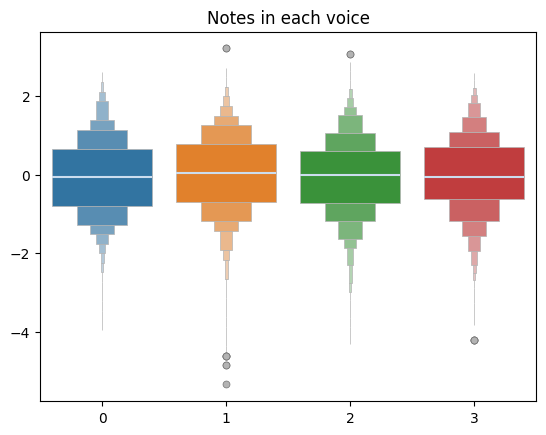

In [11]:
# check standardization
sns.boxenplot(pd.concat(data).iloc[:,:4], linewidth=.5, linecolor=".7",
              line_kws=dict(linewidth=1.5, color="#cde"),
              flier_kws=dict(facecolor=".7", linewidth=.5)).set_title("Notes in each voice")

In [12]:
# We want standard input sequence length
#   labels and input sequences get shifted by 1, therefore we need +1
new_data = []
for sequence in data:
    for i in range(0, len(sequence), (SEQ_LENGTH + 1) - SEQ_OVERLAP):
        # padding needed
        if (i + (SEQ_LENGTH + 1)) > len(sequence):
            new_data.append(pd.DataFrame(sequence[i:]).reindex(range((SEQ_LENGTH + 1)), fill_value = PAD_VALUE))
        else:
            new_data.append(pd.DataFrame(sequence[i:i+(SEQ_LENGTH + 1)].values))
            
data = new_data

Number of Sequences (was 500): 1155


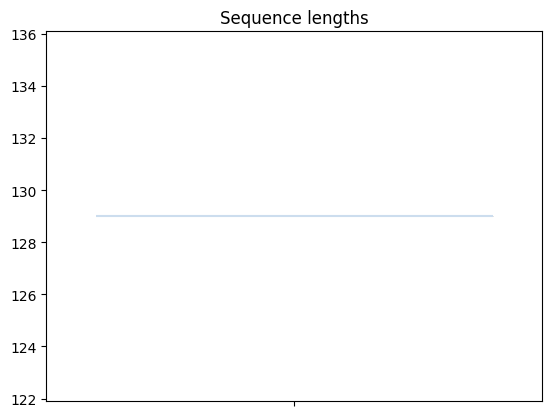

In [16]:
# check sequence lengths
sns.boxenplot([len(seq) for seq in data], linewidth=.5, linecolor=".7",
              line_kws=dict(linewidth=1.5, color="#cde"),
              flier_kws=dict(facecolor=".7", linewidth=.5)).set_title("Sequence lengths")
print("Number of Sequences (was 500):", len(data))

In [14]:
# create labels by shifting one to the right
input_seqs = []
label_seqs = []
for sequence in data:
    input_seqs.append(sequence[:-1])
    label_seqs.append(sequence[1:])
    
input_seqs = np.array(input_seqs, dtype = object)
label_seqs = np.array(label_seqs, dtype = object)
print(input_seqs[0][0:5])
print(label_seqs[0][0:5]) 

[[-0.790529720401527 -0.45050155256881885 -0.2812276168879173
  0.14228599817641904 0.0 0.0 0.0 0.0]
 [-0.790529720401527 -0.45050155256881885 -0.2812276168879173
  0.14228599817641904 0.0 0.0 0.0 0.0]
 [-0.790529720401527 -0.45050155256881885 -0.2812276168879173
  0.14228599817641904 0.0 0.0 0.0 0.0]
 [-0.790529720401527 -0.45050155256881885 -0.2812276168879173
  0.14228599817641904 0.0 0.0 0.0 0.0]
 [-0.5478834395278561 -0.45050155256881885 0.16780395402585388
  -0.42378804849470675 0.0 0.0 0.0 0.0]]
[[-0.790529720401527 -0.45050155256881885 -0.2812276168879173
  0.14228599817641904 0.0 0.0 0.0 0.0]
 [-0.790529720401527 -0.45050155256881885 -0.2812276168879173
  0.14228599817641904 0.0 0.0 0.0 0.0]
 [-0.790529720401527 -0.45050155256881885 -0.2812276168879173
  0.14228599817641904 0.0 0.0 0.0 0.0]
 [-0.5478834395278561 -0.45050155256881885 0.16780395402585388
  -0.42378804849470675 0.0 0.0 0.0 0.0]
 [-0.5478834395278561 -0.45050155256881885 0.16780395402585388
  -0.42378804849470675 

In [15]:
# create train test split
inputs_train, inputs_test, labels_train, labels_test = train_test_split(input_seqs, label_seqs, test_size = 0.15, random_state = 15)
print("(nr_samples, seq_length, features)")
print("train sizes:", inputs_train.shape, labels_train.shape)
print("test sizes:", inputs_test.shape, labels_test.shape)

(nr_samples, seq_length, features)
train sizes: (981, 128, 8) (981, 128, 8)
test sizes: (174, 128, 8) (174, 128, 8)


# MODEL INITIALIZATION